In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据准备

In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2025-02-07 21:35:34--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
正在解析主机 storage.googleapis.com (storage.googleapis.com)... 142.250.217.91, 142.251.33.91, 172.217.14.251, ...
正在连接 storage.googleapis.com (storage.googleapis.com)|142.250.217.91|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 1115394 (1.1M) [text/plain]
正在保存至: ‘shakespeare.txt.1’

shakespeare.txt.1   100%[===================>]   1.06M   982KB/s    用时 1.1s    

2025-02-07 21:35:36 (982 KB/s) - 已保存 ‘shakespeare.txt.1’ [1115394/1115394])



In [3]:
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 构造字典

In [4]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
for idx,char in enumerate(['how','are','you']):
    print(idx,char)

0 how
1 are
2 you


In [6]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [7]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


### 把莎士比亚文集分成一个一个的样本

In [9]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len
        
    def __getitem__(self, index):
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]
    
    def __len__(self):
        return self.num_seq
    
def collat_fct(batch):
    src_list = []
    trg_list = []
    for part in batch:
        src_list.append(part[:-1])
        trg_list.append(part[1:])
        
    src_list = np.array(src_list)
    trg_list = np.array(trg_list)
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64)
        

train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

## 定义模型

In [10]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        x = self.fc(output)
        return x, hidden
    
    
vocab_size = len(vocab)
sample_inputs = torch.randint(0, vocab_size, (2, 100))
    
print("{:=^80}".format(" 一层单向 LSTM "))       
for key, value in CharLSTM(vocab_size).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")
    
CharLSTM(vocab_size)(sample_inputs)[0].shape

================================== 一层单向 LSTM ===================================
            embedding.weight            paramerters num: 16640
           lstm.weight_ih_l0            paramerters num: 1048576
           lstm.weight_hh_l0            paramerters num: 4194304
            lstm.bias_ih_l0             paramerters num: 4096
            lstm.bias_hh_l0             paramerters num: 4096
               fc.weight                paramerters num: 66560
                fc.bias                 paramerters num: 65


torch.Size([2, 100, 65])

In [11]:
4 * 1024*256

1048576

In [12]:
4 * 1024*1024

4194304

## 训练

In [13]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [14]:
# 训练
def training(
    model, 
    train_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=None,
    stateful=False      # 想用stateful，batch里的数据就必须连续，不能打乱
    ):
    record_dict = {
        "train": [],
    }
    
    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
   
                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = CharLSTM(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation_lstm", save_step=1000, save_best_only=True)


model = model.to(device)
record = training(
    model, 
    train_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=save_ckpt_callback,
    )

100%|██████████| 17300/17300 [05:05<00:00, 56.56it/s, epoch=99]


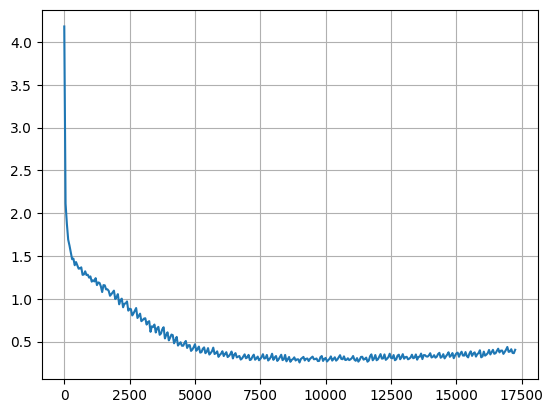

In [15]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

## 推理

In [16]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1, -1)
    hidden = None
    text_generated = []
    model.eval()
    pbar = tqdm(range(max_len))
    print(start_string, end="")
    with torch.no_grad():
        for i in pbar:
            logits, hidden = model(input_eval, hidden=hidden)
            # 温度采样
            logits = logits[0, -1, :] / temperature
            # using multinomial to sampling
            probs = F.softmax(logits, dim=-1)
            idx = torch.multinomial(probs, 1).item()
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1)
            text_generated.append(idx)
            if stream:
                print(idx2char[idx], end="", flush=True)
    return "".join([idx2char[i] for i in text_generated])


torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# load checkpoints
model.load_state_dict(torch.load("checkpoints/text_generation_lstm/best.ckpt", map_location="cpu"))
start_string = "All: "
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

/tmp/ipykernel_600/3607945331.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/text_generation_lstm/best.ckpt", map_locatio

All: a

  0%|          | 1/1000 [00:00<02:08,  7.80it/s]

nd I come by him.

PETRUCHIO:
Come on, i' God's name, speak; for what life's I have worn
That you may conquer or sound this one:


 13%|█▎        | 130/1000 [00:00<00:01, 682.35it/s]

Come, what letters of Hereford till God's name,
In most I trust my want of water:
And, for the senators, the mighty

 24%|██▍       | 245/1000 [00:00<00:00, 880.56it/s]

 prince,
Lend two the bridgling throne and the fair staring
Than at your walls, as mine hath cheepts to do,
Without a subject spent, 

 38%|███▊      | 378/1000 [00:00<00:00, 1051.00it/s]

it makes him to it,
The more than his or soul and tears are gone.

CLIFFORD:
The king is nothing: I say the tractless in
the service of yo

 52%|█████▏    | 516/1000 [00:00<00:00, 1165.95it/s]

ur daughter to his will and that with her
sworn.

PROSPERO:
Dost thou, that e'er thou wast but ladies' brawls,
And what they say that 

 65%|██████▌   | 650/1000 [00:00<00:00, 1222.11it/s]

she did lose his life?

GLOUCESTER:
You may deny that for my counsels,
Even thus the very time Aufidius caps it before
The second cur is

 79%|███████▊  | 786/1000 [00:00<00:00, 1265.60it/s]

 but a drunken made
As thou canst gradle carried and sullen venom,
And on athanting them from France speaks.

Nurse:
Now, afore 

 91%|█████████▏| 914/1000 [00:00<00:00, 1260.42it/s]

God! methinks I hear gently for thee.

AUTOLYCUS:
No, good shepherd, will you not hure

100%|██████████| 1000/1000 [00:00<00:00, 1117.73it/s]
